# Autoendoder clustering

## 1. Import necessary libraries

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np

/Users/manish/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 2. Train and test data

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 19s 2us/step


### 2.1. Prepare the input data

In [3]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) #transform 2D 28x28 matrix to 3D (28x28x1) matrix
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255 #inputs have to be between [0, 1]
x_test /= 255

## 3. Build the network

In [4]:
model = Sequential()

# decoder layers
#1st convolution layer
model.add(Conv2D(16, (3, 3) , padding='same', input_shape=(28,28,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#2nd convolution layer
model.add(Conv2D(2,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# autoencoder layers
#3rd convolution layer
model.add(Conv2D(2,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#4th convolution layer
model.add(Conv2D(16,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#output layer
model.add(Conv2D(1,(3, 3), padding='same'))
model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 2)         290       
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 2)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 2)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 2)           38        
__________

## 4. Train the model and test using test dataset

In [5]:
model.compile(optimizer='adadelta', loss='binary_crossentropy')

model.fit(x_train, x_train,
          epochs=3,
          validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 43s 722us/step - loss: 0.1343 - val_loss: 0.1038
Epoch 2/3
60000/60000 [==============================] - 43s 720us/step - loss: 0.0997 - val_loss: 0.0983
Epoch 3/3
60000/60000 [==============================] - 44s 728us/step - loss: 0.0943 - val_loss: 0.0928


In [6]:
restored_imgs = model.predict(x_test)

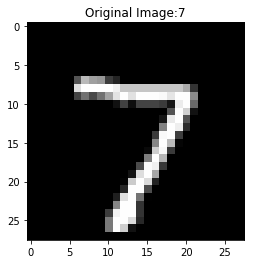

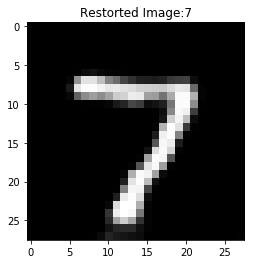

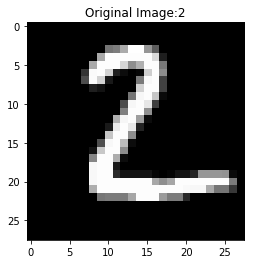

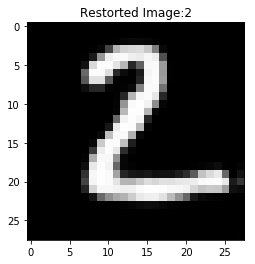

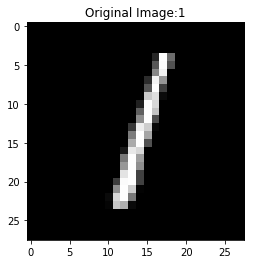

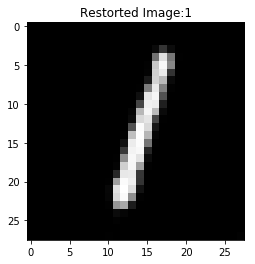

In [10]:
for i in range(3):
    plt.imshow(x_test[i].reshape(28, 28))
    label = 'Original Image:' + str(y_test[i])
    plt.title(label)
    plt.gray()
    plt.show()
    
    plt.imshow(restored_imgs[i].reshape(28, 28))
    label = 'Restorted Image:' + str(y_test[i])
    plt.title(label)
    plt.gray()
    plt.show()

## 5. Clustering using compressed representation

** Check the model layers and compressed representation.**

In [16]:
for i in range(len(model.layers)):
    print('Layer:', i, ". ", model.layers[i].output.get_shape())

Layer: 0 .  (?, 28, 28, 16)
Layer: 1 .  (?, 28, 28, 16)
Layer: 2 .  (?, 14, 14, 16)
Layer: 3 .  (?, 14, 14, 2)
Layer: 4 .  (?, 14, 14, 2)
Layer: 5 .  (?, 7, 7, 2)
Layer: 6 .  (?, 7, 7, 2)
Layer: 7 .  (?, 7, 7, 2)
Layer: 8 .  (?, 14, 14, 2)
Layer: 9 .  (?, 14, 14, 16)
Layer: 10 .  (?, 14, 14, 16)
Layer: 11 .  (?, 28, 28, 16)
Layer: 12 .  (?, 28, 28, 1)
Layer: 13 .  (?, 28, 28, 1)


In [17]:
#layer[7] is activation_3 (Activation), it is compressed representation
get_3rd_layer_output = K.function([model.layers[0].input], [model.layers[7].output])
compressed = get_3rd_layer_output([x_test])[0]

In [18]:
#layer[7] is size of (None, 7, 7, 2). this means 2 different 7x7 sized matrixes. We will flatten these matrixes.
compressed = compressed.reshape(10000,7*7*2)

In [19]:
from tensorflow.contrib.factorization.python.ops import clustering_ops
import tensorflow as tf

Instructions for updating:
Use the retry module or similar alternatives.


In [21]:
unsupervised_model = tf.contrib.learn.KMeansClustering(
                                                10, #num of clusters
                                                distance_metric = clustering_ops.SQUARED_EUCLIDEAN_DISTANCE,
                                                initial_clusters=tf.contrib.learn.KMeansClustering.RANDOM_INIT)

Instructions for updating:
Please use tf.contrib.factorization.KMeansClustering instead of tf.contrib.learn.KMeansClustering. It has a similar interface, but uses the tf.estimator.Estimator API instead of tf.contrib.learn.Estimator.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x18314c6c88>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': No

In [23]:
def return_train_input():
    data = tf.constant(compressed, tf.float32)
    return (data, None)

In [24]:
unsupervised_model.fit(input_fn=return_train_input, steps=1000)

Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/yq/9y_mkzz11yqgc8x2gs5zw_v80000gp/T/tmpo0qphcwh/model.ckpt.
INFO:tensorflow:loss = 351060.12, step = 1
INFO:tensorflow:global_step/sec: 603.851
INFO:tensorflow:loss = 208674.72, step = 101 (0.167 sec)
INFO:tensorflow:global_step/sec: 829.373
INFO:tensorflow:loss = 208157.12, step = 201 (0.120 sec)
INFO:tensorflow:global_step/sec: 803.117
INFO:tensorflow:loss = 207926.78, step = 301 (0.125 sec)
INFO:tensorflow:global_step/sec: 790.956
INFO:tensorflow:loss = 207787.03, step = 401 (0.126 sec)
INFO:tensorflow:global_step/sec: 815.549
INFO:tensorflow:loss = 207682.9, step = 501 (0.122 sec)
INFO:tensorflow

KMeansClustering(params={'num_clusters': 10, 'training_initial_clusters': 'random', 'distance_metric': 'squared_euclidean', 'random_seed': 0, 'use_mini_batch': True, 'mini_batch_steps_per_iteration': 1, 'kmeans_plus_plus_num_retries': 2, 'relative_tolerance': None})

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/yq/9y_mkzz11yqgc8x2gs5zw_v80000gp/T/tmpo0qphcwh/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


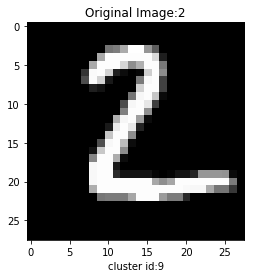

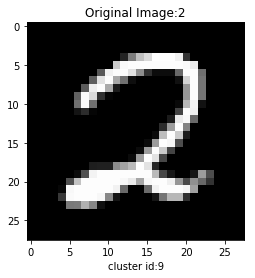

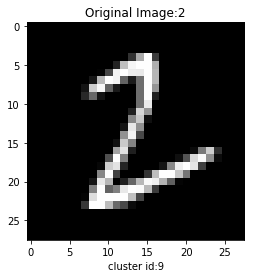

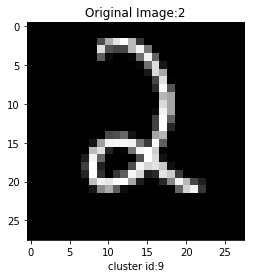

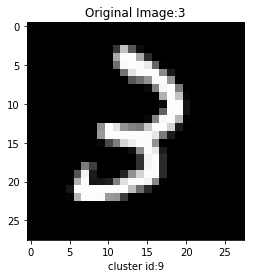

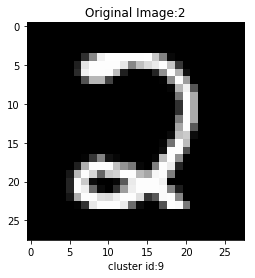

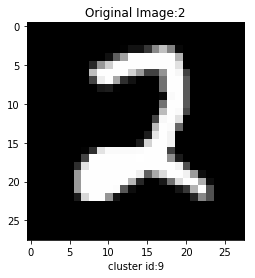

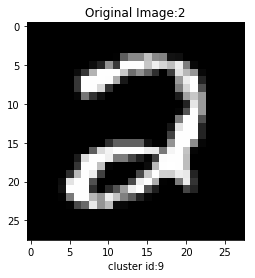

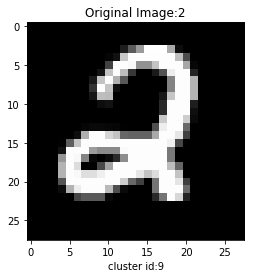

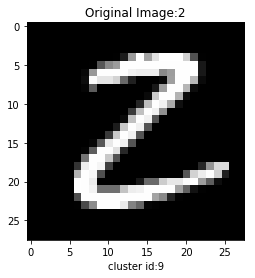

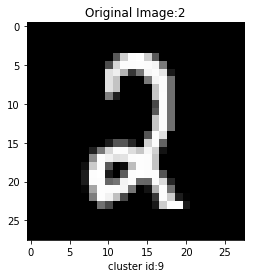

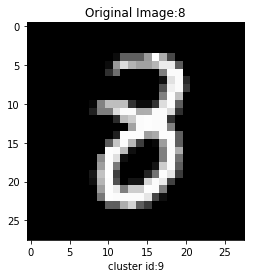

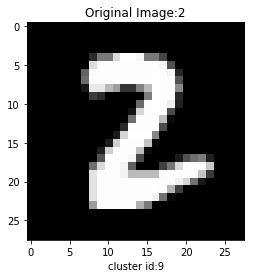

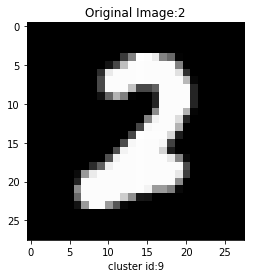

In [30]:
clusters = unsupervised_model.predict(input_fn=return_train_input)

index = 0
for i in clusters:
    current_cluster = i['cluster_idx']
    features = x_test[index]
    
    if index < 200 and current_cluster == 9:
        plt.imshow(x_test[index].reshape(28, 28))
        label = 'Original Image:' + str(y_test[index])
        plt.title(label)
        label = 'cluster id:' + str(current_cluster)
        plt.xlabel(label)
        plt.gray()
        plt.show()
    index = index + 1